***
##### This module defines a Recurrent Neural Network (RNN) model, whose kernel function is radial basis fucntion. The main task is to train a SVR model to do stock price forecasting. 

##### This module split the original data set into training set and test set. After training the SVR model with the training set, this module computes the root mean square error (RMSE) and the coefficient of determination (R<sup>2</sup>) in the test set. In order to improve the data visualization, this module also plots the actual stock price and the predicted stock price on the same figure.
 
##### Authored by Menghong Huang and Zhaosheng Li.
***

## Import Dependencies

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd             # For loading the data into dataframe

# For calculating RMSE, the usage refers to https://stackoverflow.com/a/18623635 
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import ceil

# For calculating the coefficient of determination (R^2), 
# the usage refers to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
from sklearn.metrics import r2_score

import matplotlib.dates as mdates # For converting the 'date' into numerical variable
import joblib  # For saving and loading model

# Apply normalization before feeding to LSTM using sklearn
from sklearn.preprocessing import MinMaxScaler 

# Import some dependencies that will be used in modeling RNN
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.models import load_model

## Load data into dataframe

In [2]:
df = pd.read_csv("data/GME_stock.csv")

In [3]:
df.reset_index(inplace = True)
df.set_index("date", inplace = True)

In [4]:
df.head()

,index,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,,
2002-02-13,0,9.625,10.060,9.525,10.050,19054000,6.766666
2002-02-14,1,10.175,10.195,9.925,10.000,2755400,6.733003
2002-02-15,2,10.000,10.025,9.850,9.950,2097400,6.699336
2002-02-19,3,9.900,9.900,9.375,9.550,1852600,6.430017
2002-02-20,4,9.600,9.875,9.525,9.875,1723200,6.648838


In [5]:
dates_training = pd.to_datetime(df.index[:ceil(len(df)*0.8)])
dates_test = pd.to_datetime(df.index[ceil(len(df)*0.8):])

In [6]:
close_price = df[['close_price']]

In [7]:
close_price.head()

,close_price
date,
2002-02-13,10.050
2002-02-14,10.000
2002-02-15,9.950
2002-02-19,9.550
2002-02-20,9.875


In [8]:
scaler = MinMaxScaler(feature_range = (0,1))

In [9]:
df_scaled = scaler.fit_transform(df.values)[:, 1:]
close_price = scaler.fit_transform(close_price.values)

In [10]:
time_steps = 30

In [11]:
X = []
y = []
for index in range(time_steps, df_scaled.shape[0] - time_steps):
    X.append(df_scaled[index - time_steps:index, :])
    y.append(close_price[index + time_steps, :])

In [12]:
features = X[0].shape[1]
features

6

In [13]:
df_scaled.shape[0]

4773

In [14]:
scaler.inverse_transform(np.array(y))

array([[ 11.02999973],
       [ 10.75      ],
       [ 10.39999962],
       ...,
       [147.9799957 ],
       [347.5100098 ],
       [193.6000061 ]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [16]:
X_train[0].shape

(30, 6)

In [17]:
len(X_train)

3770

In [18]:
len(X_test)

943

In [19]:
y_train[0].shape

(1,)

In [20]:
# model = load_model('LSTM_Model/LSTM_30_model.h5')

In [21]:
model = Sequential()

model.add(LSTM(units = 64, return_sequences = True, input_shape = (time_steps, features)))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 64))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.summary()
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            18176     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                3

In [22]:
model.fit(np.array(X_train), np.array(y_train), epochs = 100)

Epoch 1/100
118/118 [==============================] - 18s 64ms/step - loss: 0.0010
Epoch 2/100
118/118 [==============================] - 8s 64ms/step - loss: 2.4372e-04
Epoch 3/100
118/118 [==============================] - 8s 65ms/step - loss: 2.3848e-04
Epoch 4/100
118/118 [==============================] - 8s 64ms/step - loss: 2.1865e-04
Epoch 5/100
118/118 [==============================] - 8s 64ms/step - loss: 2.0247e-04
Epoch 6/100
118/118 [==============================] - 8s 64ms/step - loss: 2.1249e-04
Epoch 7/100
118/118 [==============================] - 8s 64ms/step - loss: 2.0733e-04
Epoch 8/100
118/118 [==============================] - 8s 65ms/step - loss: 2.2988e-04
Epoch 9/100
118/118 [==============================] - 7s 63ms/step - loss: 2.1334e-04
Epoch 10/100
118/118 [==============================] - 7s 56ms/step - loss: 2.0658e-04
Epoch 11/100
118/118 [==============================] - 8s 66ms/step - loss: 1.8595e-04
Epoch 12/100
118/118 [======================

In [23]:
# Save the trained LSTM model
model.save('LSTM_Model/LSTM_30_model.h5')

In [24]:
train_predicted_value = scaler.inverse_transform(model.predict(np.array(X_train)))
train_actual_value = scaler.inverse_transform(np.array(y_train))

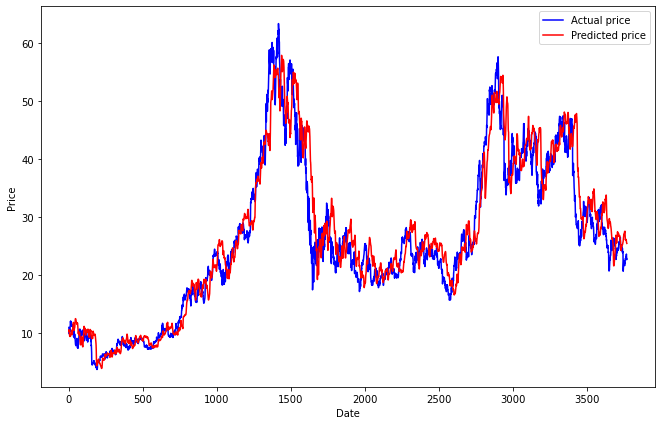

In [25]:
plt.figure(figsize = (11,7))
plt.plot(train_actual_value, color= 'blue', label= 'Actual price')
plt.plot(train_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
test_predicted_value = scaler.inverse_transform(model.predict(np.array(X_test)))
test_actual_value = scaler.inverse_transform(np.array(y_test))

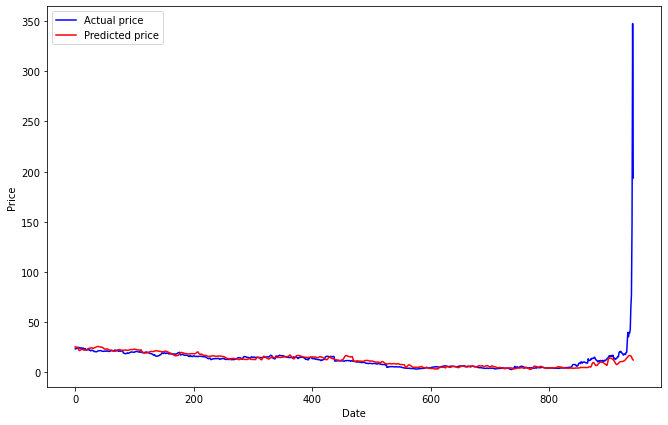

In [27]:
plt.figure(figsize = (11,7))
plt.plot(test_actual_value, color= 'blue', label= 'Actual price')
plt.plot(test_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
RMSE = sqrt(mean_squared_error(test_actual_value, test_predicted_value))
print(f'The root mean square error (RMSE) for the LSTM model is {RMSE}')

The root mean square error (RMSE) for the LSTM model is 13.721125686824168


In [29]:
R_2 = r2_score(test_actual_value, test_predicted_value)
print(f'The coefficient of determination (R^2) for the LSTM model is {R_2}')

The coefficient of determination (R^2) for the LSTM model is 0.14840696653717977


## Remove the last 10 days

In [30]:
test_predicted_value = scaler.inverse_transform(model.predict(np.array(X_test[:-11])))
test_actual_value = scaler.inverse_transform(np.array(y_test[:-11]))

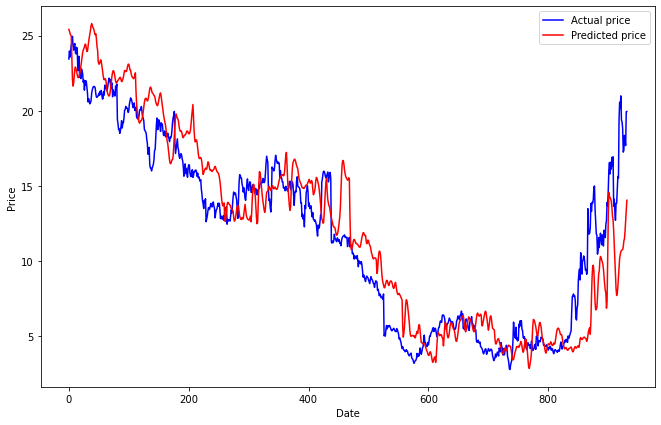

In [31]:
plt.figure(figsize = (11,7))
plt.plot(test_actual_value, color= 'blue', label= 'Actual price')
plt.plot(test_predicted_value, color= 'red', label= 'Predicted price') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
RMSE = sqrt(mean_squared_error(test_actual_value, test_predicted_value))
print(f'The root mean square error (RMSE) for the LSTM model is {RMSE}')

The root mean square error (RMSE) for the LSTM model is 2.458817004864567


In [33]:
R_2 = r2_score(test_actual_value, test_predicted_value)
print(f'The coefficient of determination (R^2) for the LSTM model is {R_2}')

The coefficient of determination (R^2) for the LSTM model is 0.8334944088290899
